In [624]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Implementation in python

In [625]:
def get_ticker(name: str):
    """ 
    Get the ticker of a company
    """
    tickers_list = pd.read_csv("Tickers_list.csv")
    tickers_list = tickers_list[["Symbol", "Name"]]
    tickers_list["Name"] = tickers_list["Name"].str.lower()
    return tickers_list.loc[tickers_list["Name"].str.contains(name)]

get_ticker("tesla")

,Symbol,Name
6285,TSLA,tesla inc. common stock


In [626]:
def get_and_save(t: str):
    """
    Get the stocks using the yahoo finance API and save the DataFrame in a parquet file
    """
    ticker = yf.Ticker(t)
    df_stocks = ticker.history(period='max').to_parquet("TESLA_stocks.parquet")
    return pd.read_parquet("TESLA_stocks.parquet")

df = get_and_save("TSLA")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3752 entries, 2010-06-29 00:00:00-04:00 to 2025-05-28 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3752 non-null   float64
 1   High          3752 non-null   float64
 2   Low           3752 non-null   float64
 3   Close         3752 non-null   float64
 4   Volume        3752 non-null   int64  
 5   Dividends     3752 non-null   float64
 6   Stock Splits  3752 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 234.5 KB



### Dynamic visual representation of the stock prices

In [627]:
def initial_visualization(df, target, title: str):
    """ 
    Get a dynamic visualization of the stock prices
    """
    return px.line(df, df.index, df[target], title=title)

initial_visualization(df, target="Close", title="TESLA stock prices")

In [628]:
def format_dataset(df) : 
    """ 
    Clean and format the dataset.
    """
    df = df.reset_index()
    df = df[["Date", "Close"]]
    df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")
    df["Date"] = pd.to_datetime(df["Date"])
    return df

df = format_dataset(df)


### Define the probability of each state occuring. (Most delicate part)

In [629]:
# States creation function

def assign_states(df, target):
    """
    Creation function of the stats consequent increase, slight increase, stagnation, slight drop, consequent drop
    """
    growth = df[target].pct_change()
    df["state"] = "défault" # by default state
    df.loc[growth <= -0.08 , "state"] = 0  # consequent drop
    df.loc[(growth > -0.08) & (growth <= -0.005), "state"] = 1  # slight drop
    df.loc[(growth > -0.005) & (growth < 0.005), "state"] = 2  # stagnation
    df.loc[(growth >= 0.005) & (growth < 0.08), "state"] = 3  # slight increase
    df.loc[growth >= 0.08, "state"] = 4  # consequent increase
    df = df.drop(df[df["state"] == "défault"].index) # Supress the first value due to .pct_change()
    df["state"] = df["state"].astype('int8')
    return df


In [630]:
# Creation of the transition matrix

def transition_matrix(states, n_states = 5) : 
    """
    Create the transition matrice for the Markov chain
    """
    matrix = np.zeros((n_states, n_states))
    for (i, j) in zip(states[:-1], states[1:]) :
        matrix[i, j] += 1
    matrix = matrix / matrix.sum(axis=1, keepdims=True)

    return pd.DataFrame(data = matrix, index = ["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"], columns=["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"])

# Apply the functions 
df = assign_states(df, target="Close")
tm = transition_matrix(df["state"], n_states=5)

In [631]:
tm

,consequent_drop,slight_drop,stagnation,slight_increase,consequent_increase
consequent_drop,0.016129,0.354839,0.112903,0.419355,0.096774
slight_drop,0.024028,0.368198,0.164664,0.418375,0.024735
stagnation,0.012103,0.394856,0.183056,0.396369,0.013616
slight_increase,0.011834,0.377383,0.187377,0.401709,0.021696
consequent_increase,0.010989,0.417582,0.153846,0.329670,0.087912


# Get the current state and the probabilities for the future state

In [632]:
def Display_probs_next_move(df, transition_df):
    """
    Get the current state and its transition probability.
    """
    states = ["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"]
    for i, state in zip(range(5), states):
        if df["state"].iloc[-1] == i:    
            next_probs = pd.DataFrame(data= transition_df.to_numpy()[i, :]).T.rename(columns={0:"consequent_drop", 1:"slight_drop", 2: "stagnation", 3: "slight_increase", 4: "consequent_increase"})
            current_state = pd.DataFrame({"current state": state}, index=[0])
            return pd.concat([current_state, next_probs], axis=1)


next_prob = Display_probs_next_move(df, tm)
next_prob

,current state,consequent_drop,slight_drop,stagnation,slight_increase,consequent_increase
0,slight_drop,0.024028,0.368198,0.164664,0.418375,0.024735


# Get the number of times of each states historically

In [633]:
def historical_number_of_states(df, target):
    """ 
    Get the historical number of states
    """
    states_number = pd.DataFrame(data = df[target].value_counts()).sort_values(by=target, ascending=True).reset_index()
    states_number[target] = states_number[target].astype('object')

    for i, j in zip(range(5), ["consequent_drop", "slight_drop", "stagnation", "slight_increase", "consequent_increase"]):
        states_number.loc[states_number[target] == i, target] = j
    states_number = states_number.set_index(target)

    return states_number

# Apply the function 
states_number = historical_number_of_states(df, target="state")
states_number


,count
state,
consequent_drop,62
slight_drop,1416
stagnation,661
slight_increase,1521
consequent_increase,91


# Compute the stationary matrix and the number of iterations needed to reach it


In [634]:
def reach_stable_states(transition_df):
    """
    Computes at which iteration the stationary matrix is reached.
    Returns the number of iterations needed and the stationary matrix itself
    """
    previous = transition_df.to_numpy()
    base = transition_df.to_numpy()
    count = 0
    while True:
        current = previous.dot(base)
        count += 1
        if np.allclose(current, previous, atol=1e-5) :
            break
        previous = current
    return count, pd.DataFrame(data=current, index=transition_df.index, columns=transition_df.columns)


iterations, stationary_matrix = reach_stable_states(tm)

print(f"Matrix convergence in {iterations} iterations")
print("Stationary Matrix:")
print(stationary_matrix)

Matrix convergence in 5 iterations
Stationary Matrix:
                     consequent_drop  slight_drop  stagnation  \
consequent_drop             0.016536     0.377593    0.175995   
slight_drop                 0.016536     0.377593    0.175995   
stagnation                  0.016536     0.377593    0.175995   
slight_increase             0.016536     0.377593    0.175995   
consequent_increase         0.016536     0.377593    0.175995   

                     slight_increase  consequent_increase  
consequent_drop             0.405605              0.02427  
slight_drop                 0.405606              0.02427  
stagnation                  0.405606              0.02427  
slight_increase             0.405606              0.02427  
consequent_increase         0.405605              0.02427  


##### According to the memoryless property of the markov chains, the probability on the market are the following. 

In [635]:
next_prob_long_term = Display_probs_next_move(df, stationary_matrix)
next_prob_long_term.drop("current state", axis=1)

,consequent_drop,slight_drop,stagnation,slight_increase,consequent_increase
0,0.016536,0.377593,0.175995,0.405606,0.02427


### Visualize the two transition probability matrix (for the next event and at the equilibrium of the market)

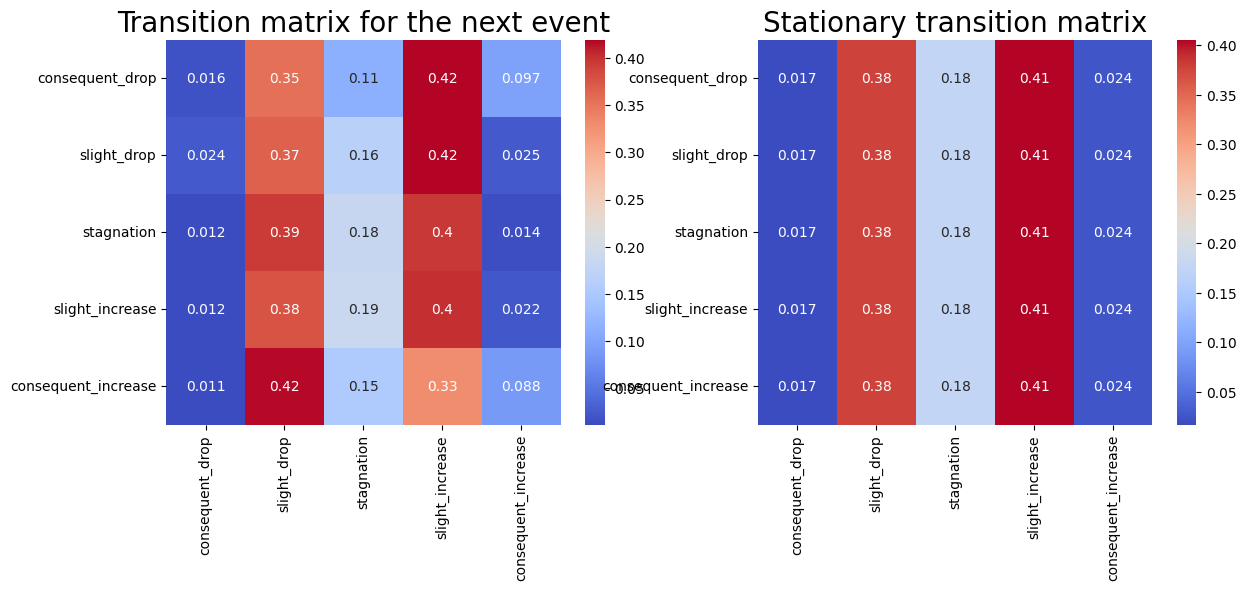

In [636]:
def view_matrix(transition_df, stationary_transition_df):
    """
    Display both the transition matrix for the next event and the transition matrix when the market is considered at its equilibirum
    """
    plt.figure(figsize=(14, 5))
    for (i, matrix, title) in zip(range(1, 3), [transition_df, stationary_transition_df], ["Transition matrix for the next event", "Stationary transition matrix"]):
        plt.subplot(1, 2, i)
        sns.heatmap(data=matrix, cmap="coolwarm", annot=True)
        plt.title(title, fontsize=20)
    return plt.show()

view_matrix(tm, stationary_matrix)

# Installation of an automated pipeline

In [637]:
from IPython.display import display

def stocks_markov(company: str):
    """
    Automated pipeline which displays the Markov chains for the chosen company.
    Displays the name of the company, the DataFrame, current state's transition probabilities, and the stationary matrix.
    """
    df_ticker = get_ticker(company)
    df_ticker = df_ticker["Symbol"].iloc[0]
    df = get_and_save(df_ticker)
    df = format_dataset(df)
    df = assign_states(df, target="Close")

    tm = transition_matrix(df["state"], n_states=5)
    next_prob = Display_probs_next_move(df, tm)
    states_number = historical_number_of_states(df, target="state")
    iterations, stationary_matrix = reach_stable_states(tm)

    print(f"Overview of {company}'s stock prices:")
    display(df)
    display(initial_visualization(df, target="Close", title=f"{company}'s stock prices"))
    print("Current state: ")
    display(next_prob["current state"].iloc[0])
    print("Number of each state on this market historically")
    display(states_number)
    display(view_matrix(tm, stationary_matrix))

    return None



Overview of apple's stock prices:


,Date,Close,state
1,1980-12-15,0.093453,1
2,1980-12-16,0.086594,1
3,1980-12-17,0.088737,3
4,1980-12-18,0.091309,3
5,1980-12-19,0.096882,3
...,...,...,...
11201,2025-05-22,201.360001,2
11202,2025-05-23,195.270004,1
11203,2025-05-27,200.210007,3
11204,2025-05-28,200.419998,2


Current state: 


'slight_drop'

Number of each state on this market historically


,count
state,
consequent_drop,62
slight_drop,4195
stagnation,2338
slight_increase,4505
consequent_increase,105


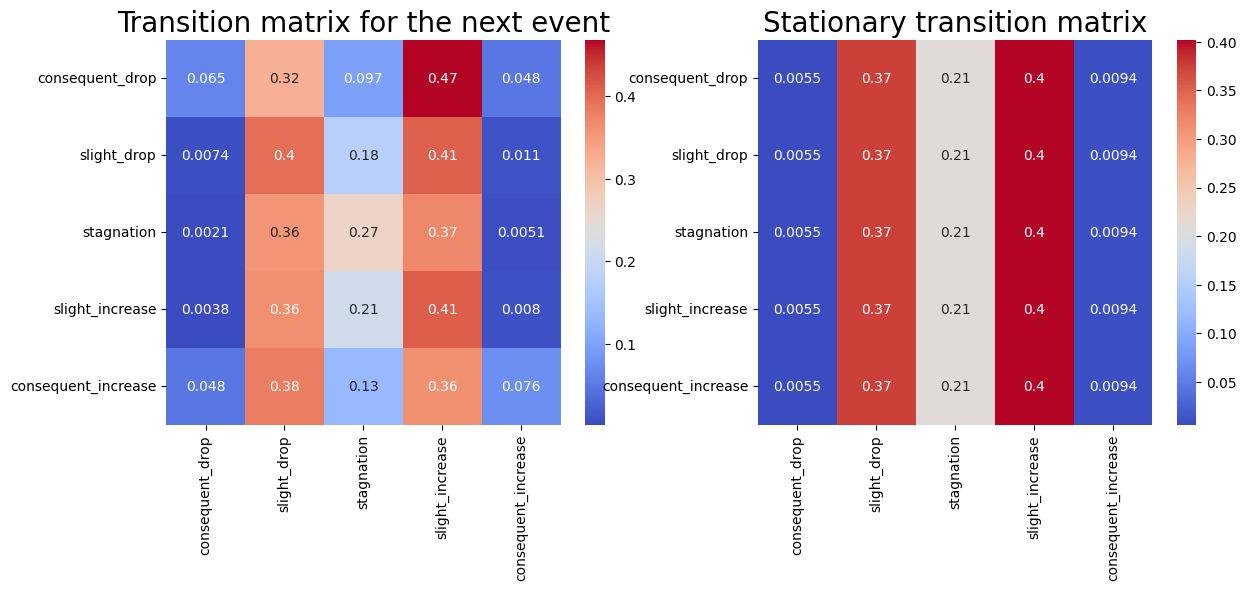

None

In [638]:
stocks_markov("apple")


Overview of microsoft's stock prices:


,Date,Close,state
1,1986-03-14,0.061726,3
2,1986-03-17,0.062791,3
3,1986-03-18,0.061194,1
4,1986-03-19,0.060130,1
5,1986-03-20,0.058533,1
...,...,...,...
9875,2025-05-22,454.859985,3
9876,2025-05-23,450.179993,1
9877,2025-05-27,460.690002,3
9878,2025-05-28,457.359985,1


Current state: 


'stagnation'

Number of each state on this market historically


,count
state,
consequent_drop,25
slight_drop,3363
stagnation,2729
slight_increase,3725
consequent_increase,37


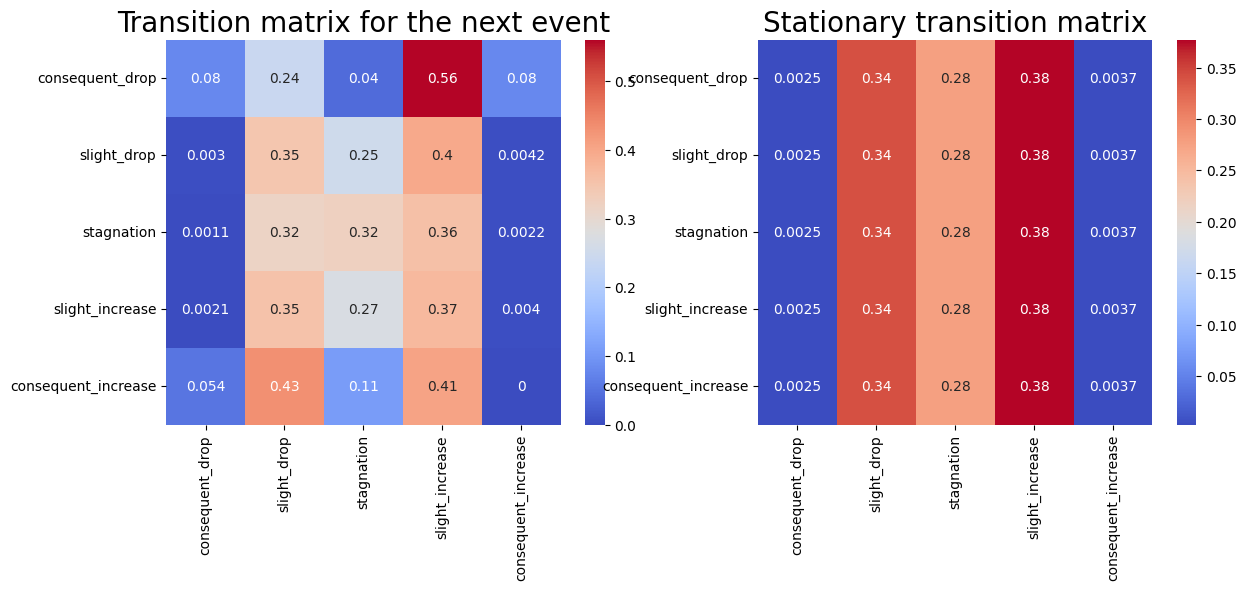

None

In [639]:
stocks_markov("microsoft")